# Chap 6 Linear Model Selection and Regularization

## Lab1 Hitters dataset

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations

from sklearn.linear_model import *
from sklearn.preprocessing import *
from sklearn.feature_selection import *
from sklearn.metrics import *
from sklearn.model_selection import *

In [60]:
hitters = pd.read_csv('../data/Hitters.csv').dropna()
assert hitters.isna().sum().sum() == 0
hitters.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            311, 312, 313, 314, 315, 317, 318, 319, 320, 321],
           dtype='int64', length=263)

In [61]:
# Create dummy variables for qualitative features
qual = ['League', 'Division', 'NewLeague']
hitters = pd.get_dummies(hitters,columns= qual)
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,1,0,0,1,1,0


## Lab 1: Subset Selection Methods

## 6.5.1 Best subset selection

Perform best subset selection by identifying the best model that contains a given number of predictors, where best is quantified using RSS.

### [JW version](https://nbviewer.jupyter.org/github/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%206.ipynb)

In [62]:
def get_models(k, X, y):
    X_combos = combinations(list(X.columns), k)
    
    models = []
    for X_label in X_combos:
        X_smf = ' + '.join(X_label)
        f     = 'Salary ~ {}'.format(X_smf)
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        models += [(f, model)]
    return models

def min_rss(statsmodels):
    return sorted(statsmodels, key=lambda tup: tup[1].ssr)[0]

def min_bic(statsmodels):
    return sorted(statsmodels, reverse=False, key=lambda tup: tup[1].bic)[0]

def max_adjr2(statsmodels):
    return sorted(statsmodels, reverse=True, key=lambda tup: tup[1].rsquared_adj)[0]


### Which model with 2 predictors yields lowest RSS score?

In [63]:
X = hitters.drop('Salary', axis=1)
y = hitters['Salary']

k = 2
subset = get_models(k, X, y)

print(f'This model yields the lowest RSS score for the subset of models with {format(k)} predictors:')
display(min_rss(subset))

print(f'This model yields the highest adjusted R-squared score for the subset of models with {format(k)} predictors:')
max_adjr2(get_models(2, X, y))

This model yields the lowest RSS score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1510555b0>)

This model yields the highest adjusted R-squared score for the subset of models with 2 predictors:


('Salary ~ Hits + CRBI',
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x152768dc0>)

In [64]:
X.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_A', 'League_N', 'Division_E', 'Division_W',
       'NewLeague_A', 'NewLeague_N'],
      dtype='object')

How do the the maximum $R^2$, minimum RSS, and BIC statistics vary for each subset with k predictors? 

First we fit all possible models in each subset of models with k predictors. This turns out to be a very computationally expensive process, running on my laptop for 30 minutes yielded results up to only k=6 and occupied 30GB of memeory. Not suprising as number of possible combinations without repetition is given by:

$$\frac{p!}{k!(p-k)!}$$

Where *p* is number of predictors to choose from and we choose *k* of them.

In this example p=22, there are 22 predictors.

For k = 4 the number of possible combinations is given by:

$$\frac{22!}{4!x 18!} = 74,613$$


[Text(0.5, 0, 'k'), Text(0, 0.5, 'combinations')]

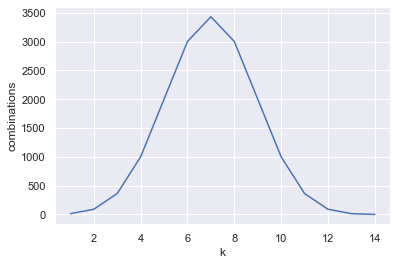

In [65]:
from scipy.special import factorial

n =14
k = np.arange(1, n+1)
y = factorial(n)/(factorial(k) * factorial(n-k))

ax = sns.lineplot(x=k,y=y)
ax.set(xlabel='k', ylabel='combinations')

The plot above shows that there up to ~700,000 possible combinations of the predictors without repetition for some values of k when p = 22

The ISL authors provide comparison of the $R^2$ statistic for all combinations of 19 predictors. When p=19 the max number of combinations for any given subset is reduced by 10x, when p=10 the max combinations is reduced by ~2000x. 

My current machine maxed out its memory trying to compute all models for p=22. I'll try p=14 by picking 14 of the predictors for brevity. 



In [66]:
# Pick arbitrary subset of predictors to save compute/memory
X= hitters.loc[:, 'AtBat':'PutOuts']
y= hitters['Salary']

model_subsets = []
for k in range(1,7):
    subset = get_models(k,X,y)
    model_subsets += [subset]
    print(f'Progress : k = {format(k)}, done,')

# Try it but it works slowly.

Progress : k = 1, done,
Progress : k = 2, done,
Progress : k = 3, done,
Progress : k = 4, done,
Progress : k = 5, done,
Progress : k = 6, done,


Text(0.5, 1.0, 'BIC')

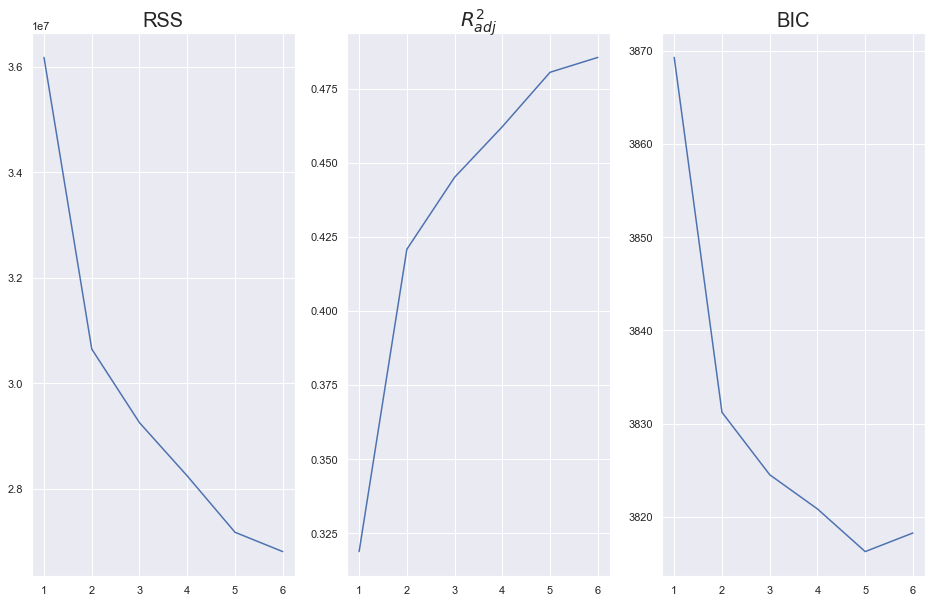

In [67]:
rss   = [min_rss(m)[1].ssr for m in model_subsets]
bic = [min_bic(m)[1].bic for m in model_subsets]
adjr2 = [max_adjr2(m)[1].rsquared_adj for m in model_subsets]

k     = np.arange(1, len(rss)+1)

_, axes = plt.subplots(1,3,figsize=[16,10])


sns.lineplot(x=k, y=rss,ax = axes[0])
sns.lineplot(x=k, y=adjr2,ax = axes[1])
sns.lineplot(x=k, y=bic,ax = axes[2])
axes[0].set_title('RSS',fontsize=20)
axes[1].set_title('$R_{adj}^2$',fontsize=20)
xes[2].set_title('BIC',fontsize=20)

The stats above seem to confer that a model with around 8 predictors is best. But has each method chosen the same or similar models

In [68]:
best_subset_6 = list(min_rss(model_subsets[5])[1].params.index)[1:]
print(best_subset_6)

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']


In [69]:
list(max_adjr2(model_subsets[5])[1].params.index)[1:]

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']

In [70]:
list(min_bic(model_subsets[5])[1].params.index)[1:]

['AtBat', 'Hits', 'Walks', 'CRuns', 'CWalks', 'PutOuts']

All three statisticis yield the same model for the subset with 6 predictors. This is expected for RSS and R-squared stats because they are related.

### 6.5.2 Forward and Backward Stepwise Selection

In [71]:
def forward_stepwise(X, y, results=[(0, [])]):
    # List predictors that havent's been used so far
    p_all    = list(X.columns)
    p_used   = results[-1][1]
    p_unused = [p for p in p_all if p not in p_used]
    
    # Job done, exit recursion
    if not p_unused:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'rss': rss, 'predictors': preds}).drop(0).reset_index()
    
    # Get rss score for each possible additional predictor
    r = []
    for p in p_unused:
        f     = 'Salary ~ {}'.format('+'.join([p]+p_used))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, [p]+p_used)]
    
    # Choose predictor which yields lowest rss
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    # Recursive call to self
    return forward_stepwise(X, y, new_results)

In [72]:
def backward_stepwise(X, y, results=[]):
    # List predictors that havent's been used so far
    p_all    = list(X.columns)

    # Check if we're starting out here
    if not results:
        # Fit model with all features
        f     = 'Salary ~ {}'.format('+'.join(p_all))
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        # Begin backward stepwise recursion
        return backward_stepwise(X, y, [(model.ssr, p_all)])
    else:
        p_used = results[-1][1]
    
    # Job done, exit recursion
    if len(p_used) == 1:
        rss   = [r[0] for r in results]
        preds = [r[1] for r in results]
        return pd.DataFrame({'rss': rss, 'predictors': preds})    
    
    # Get rss score for each possible removed predictor
    r = []
    for p in p_used:
        p_test = [i for i in p_used if i != p]
        f     = 'Salary ~ {}'.format('+'.join(p_test))
        # Fit model
        model = smf.ols(formula=f, data=pd.concat([X, y], axis=1)).fit()
        r     += [(model.ssr, p_test)]
    
    min_rss     = sorted(r, key=lambda tup: tup[0])[0]   
    new_results = results + [min_rss]
    return backward_stepwise(X, y, new_results)

In [73]:
scaler = StandardScaler()
X = scaler.fit_transform(hitters.loc[:, 'AtBat':'PutOuts'])
X_new = pd.DataFrame(X)
X_new.columns = hitters.loc[:, 'AtBat':'PutOuts'].columns
y = hitters['Salary']

forward_stepwise  = forward_stepwise(X_new, y)
print(forward_stepwise)
print('-'*30)
backward_stepwise = backward_stepwise(X_new, y)
print(backward_stepwise)

    index           rss                                         predictors
0       1  4.542829e+07                                          [PutOuts]
1       2  4.532160e+07                                   [Years, PutOuts]
2       3  4.522233e+07                             [CRBI, Years, PutOuts]
3       4  4.501844e+07                      [CRuns, CRBI, Years, PutOuts]
4       5  4.485676e+07              [CAtBat, CRuns, CRBI, Years, PutOuts]
5       6  4.477311e+07       [CHits, CAtBat, CRuns, CRBI, Years, PutOuts]
6       7  4.470303e+07  [AtBat, CHits, CAtBat, CRuns, CRBI, Years, Put...
7       8  4.426874e+07  [Runs, AtBat, CHits, CAtBat, CRuns, CRBI, Year...
8       9  4.416942e+07  [Walks, Runs, AtBat, CHits, CAtBat, CRuns, CRB...
9      10  4.411388e+07  [RBI, Walks, Runs, AtBat, CHits, CAtBat, CRuns...
10     11  4.409301e+07  [CHmRun, RBI, Walks, Runs, AtBat, CHits, CAtBa...
11     12  4.404634e+07  [HmRun, CHmRun, RBI, Walks, Runs, AtBat, CHits...
12     13  4.403416e+07  

In [74]:
print('Best Subset Selection       : {}'.format(sorted(best_subset_6)))
print('Forward Stepwise Selection  : {}'.format(sorted(forward_stepwise.loc[5]['predictors'])))
print('Backward Stepwise Selection : {}'.format(sorted(backward_stepwise.loc[8]['predictors'])))

Best Subset Selection       : ['AtBat', 'CRuns', 'CWalks', 'Hits', 'PutOuts', 'Walks']
Forward Stepwise Selection  : ['CAtBat', 'CHits', 'CRBI', 'CRuns', 'PutOuts', 'Years']
Backward Stepwise Selection : ['AtBat', 'CAtBat', 'CHits', 'CWalks', 'Runs', 'Years']


The above results show that Backward Stepwise Selection chooses the same 6 predictors as Best Subset Selection. Forward Stepwise Selection chooses all but one of the same predictors.

Backward Stepwise Selection therefore looks like the best approach as it makes the same optimal selection as best subset selection, but with significantly lower computational cost.

### 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [90]:
def best_subset_rss(X, y):
    model_subsets = []
    for k in range(len(X.columns)):
        k=k+1
        subset = get_models(k, X, y)
        model_subsets += [subset]
        print('Best subset selected: k = {}/{}, done'.format(k, len(X.columns)))
    # Get best rss score for each subset
    return [min_rss(m) for m in model_subsets]

def mse(y_hat, y):
    return np.sum(np.square(y_hat - y)) / y.size

In [91]:
np.random.seed(1)
train = np.random.rand(len(hitters)) < 0.5

response = 'Salary'

X_train = hitters[train].loc[:, 'AtBat':'PutOuts']
X_test = hitters[~train].loc[:,'AtBat':'PutOuts']
y_train =hitters[train][response]
y_test =hitters[~train][response]

best_subsets = best_subset_rss(X_train, y_train)

Best subset selected: k = 1/14, done
Best subset selected: k = 2/14, done
Best subset selected: k = 3/14, done
Best subset selected: k = 4/14, done
Best subset selected: k = 5/14, done
Best subset selected: k = 6/14, done
Best subset selected: k = 7/14, done
Best subset selected: k = 8/14, done
Best subset selected: k = 9/14, done
Best subset selected: k = 10/14, done
Best subset selected: k = 11/14, done
Best subset selected: k = 12/14, done
Best subset selected: k = 13/14, done
Best subset selected: k = 14/14, done


,preditors,MSE
0,1,178139.358427
1,2,165215.400785
2,3,170773.977180
3,4,154020.720967
4,5,147281.971965
5,6,148387.589992
6,7,149105.946391
7,8,138481.274569
8,9,133463.544833
9,10,134906.763925


<AxesSubplot:xlabel='preditors', ylabel='MSE'>

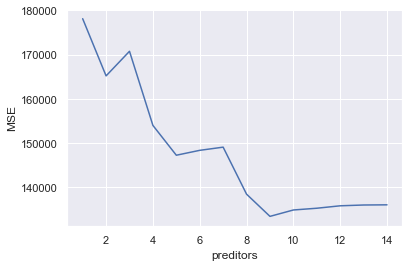

In [92]:
# Using 50% hold out set (validation set)
MSEs= []
for m in best_subsets:
    model = m[1]
    y_hat = model.predict(X_test)
    r =mse(y_hat, y_test)
    MSEs += [r]

results = pd.DataFrame({'preditors': np.arange(1,15),'MSE':MSEs})
display(results)
sns.lineplot(x='preditors', y ='MSE', data= results)